In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Lambda, Concatenate
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2 as cv
from scipy.signal import resample
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.applications import VGG16

In [ ]:
root = '/content/drive/MyDrive/Final Year Project  /Training Data/PapilaDB-PAPILA-9c67b80983805f0f886b068af800ef2b507e7dc0/'

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import Conv2DTranspose, concatenate
from keras.models import Model

In [ ]:
model.summary()

In [ ]:
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

inputs = base_model.input

# Get the output from the last layer of the base model
x = base_model.layers[-1].output

# Add the decoder layers
x = Conv2DTranspose(256, (2, 2), strides=(2, 2),activation='relu', padding='same')(x)
x = concatenate([x, base_model.get_layer('block_13_expand_relu').output], axis=-1)
x = Conv2DTranspose(128, (2, 2), strides=(2, 2),activation='relu', padding='same')(x)
x = concatenate([x, base_model.get_layer('block_6_expand_relu').output], axis=-1)
x = Conv2DTranspose(64, (2, 2), strides=(2, 2),activation='relu', padding='same')(x)
x = concatenate([x, base_model.get_layer('block_3_expand_relu').output], axis=-1)
x = Conv2DTranspose(32, (2, 2), strides=(2, 2),activation='relu', padding='same')(x)
x = concatenate([x, base_model.get_layer('block_1_expand_relu').output], axis=-1)
x = Conv2DTranspose(16, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
x = Conv2DTranspose(3, (1, 1), activation='softmax')(x)
# Define the model
model = Model(inputs, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [ ]:
model.summary()

Load training images

In [ ]:
img_names = sorted(os.listdir(root + "FundusImages"))
images = np.empty((int(len(img_names)*2), 256, 256, 3),dtype=np.uint8)
done = 0
for i in img_names:
  image = (cv.imread(root + "FundusImagesResized/" + i))
  images[done*2] = image
  images[done*2+1] = image
  done +=1
  print(str(int(100* (done/488)))+'% done')

Load training masks

In [ ]:
mask_names = sorted(os.listdir(root + "ExpertsSegmentations/Masks"))
masks = np.empty((int(len(mask_names)), 256, 256, 3),dtype=np.uint8)
done = 0
for i in mask_names:
  image = cv.imread(root + "ExpertsSegmentations/Masks/"+ i[:8]+'_exp1.png')
  masks[done] = image
  done +=1
  print(str(int(100* (done/976)))+'% done')

Split Testing and training data

In [ ]:
train_images = images[:488]
train_masks = masks[:488]
val_images = images[488:]
val_masks = masks[488:]

Train model

In [ ]:
model.fit(
    train_images,
    train_masks,
    batch_size=10,
    epochs=10,
    validation_data=(val_images, val_masks))

In [ ]:
predicions = model.predict(images)
one_hot_preds = tf.one_hot(tf.argmax(predicions, axis=-1), depth=3)
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
one_hot_preds = cv.convertScaleAbs(one_hot_preds.numpy().clip(0, 1))

16/16 [==============================] - 11s 429ms/step


In [ ]:
mask_names = sorted(os.listdir(root + "FundusImages"))
output = root+'ExpertsSegmentations/MasksPredicted'
done = 0
for i in mask_names:
  cv.imwrite((output+'/'+ i[:8]+'mask.png'),one_hot_preds[done]) 
  done +=1
  print(str(int(200* (done/976)))+'% done')

In [ ]:
mask_names = sorted(os.listdir(root + "ExpertsSegmentations/MasksPredicted"))
masks = np.empty((int(len(mask_names)), 256, 256, 3))
done = 0
for i in mask_names:
  image = cv.imread(output+'/'+ i)
  masks[done] = image
  done +=1
  print(str(int(100* (done/488)))+'% done')

In [ ]:
img_names[12]

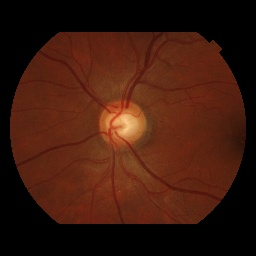

In [ ]:
cv2_imshow(image)

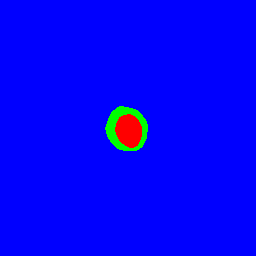

In [ ]:
cv2_imshow(masks[6]*255)

In [ ]:
cv2_imshow(one_hot_preds[4]*255)

In [ ]:
model.save('/content/drive/MyDrive/Final Year Project/Models/Exstract6.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Final Year Project/Models/Exstract4.h5')

In [ ]:
cv2_imshow(x)

In [ ]:
cv.drawContours(x, [cup_contour], -1, (0, 0, 0), 2)

In [ ]:
one_hot_preds = cv.convertScaleAbs(masks.clip(0, 1))

In [ ]:
concatenated_list = [
preds = one_hot_preds *255
done = 0
for i in preds:
  # Convert to grayscale
  gray = cv.cvtColor(i, cv.COLOR_BGR2GRAY)
  # Apply median blur
  gray_blur = cv.medianBlur(gray, 5)

  ret, thresh1 = cv.threshold(gray_blur, 90, 255, 0)
  ret, thresh2 = cv.threshold(gray_blur, 60, 255, 0)

  thresh2[thresh1==255] = 0

  contours1, hierarchy1 = cv.findContours(thresh1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  contours2, hierarchy2 = cv.findContours(thresh2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  if(len(contours1)>0 and len(contours2)>0):
    contours1 = np.array(contours1[0])
    contours2 = np.array(contours2[0])

    contours1 = np.squeeze(contours1)
    contours2 = np.squeeze(contours2)
    target_size = 16
    current_size = contours1[0].shape[0]

    if current_size > target_size:
        factor = int(current_size / target_size)
        contours1[0] = resample(contours1[0], target_size, axis=0)

    elif current_size < target_size:
        factor = int(target_size / current_size)
        contours1 = np.repeat(contours1, factor, axis=0)
        contours1 = resample(contours1, target_size, axis=0)
    current_size = contours2.shape[0]

    if current_size > target_size:
        factor = int(current_size / target_size)
        contours2 = resample(contours2, target_size, axis=0)

    elif current_size < target_size:
        factor = int(target_size / current_size)
        contours2 = np.repeat(contours2, factor, axis=0)
        contours2 = resample(contours2, target_size, axis=0)

    concatenated_array = np.concatenate((contours1, contours2), axis=0)
    concatenated_array = np.reshape(concatenated_array, (2, 16, 2))
    concatenated_list.append(concatenated_array)

  done +=1
  print(str(int(100* (done/488)))+'% done')
concatenated_array = np.array(concatenated_list)

print(len(concatenated_array))
print(concatenated_array[0].shape)

In [ ]:
np.savetxt((root + 'ExpertsSegmentations/ConcatenatedPredicted/concatenated_array.csv'), concatenated_array.reshape(-1, 32), delimiter=",") 

In [ ]:
concatenated_array = np.loadtxt(root+'/ExpertsSegmentations/ConcatenatedPredicted/concatenated_array.csv', delimiter=',')
concatenated_array = concatenated_array.reshape(-1, 2, 16, 2)
print(concatenated_array.shape)

In [ ]:
image = cv.imread('/content/RET002OD.jpg')
image = np.expand_dims(image, axis=0)

In [ ]:
predicions = model.predict(image)
one_hot_preds = tf.one_hot(tf.argmax(predicions, axis=-1), depth=3)
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
one_hot_preds = cv.convertScaleAbs(one_hot_preds.numpy().clip(0, 1))